In [0]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
from tqdm import tqdm_notebook as tqdm

import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim


import argparse
from itertools import chain
import torch.nn.functional as F
from torch.autograd import Variable

import imageio
import scipy
from progressbar import ETA, Bar, Percentage, ProgressBar

import cv2
import numpy as np
import pandas as pd
# from scipy.misc import imresize
import scipy.io

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")

PyTorch Version:  1.4.0
Torchvision Version:  0.5.0
Using the GPU!


In [0]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
class Discriminator(nn.Module):
    def __init__(
            self,
            ):

        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 4, 2, 1, bias=False)
        self.relu1 = nn.LeakyReLU(0.2, inplace=True)

        self.conv2 = nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(64 * 2)
        self.relu2 = nn.LeakyReLU(0.2, inplace=True)

        self.conv3 = nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(64 * 4)
        self.relu3 = nn.LeakyReLU(0.2, inplace=True)

        self.conv4 = nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(64 * 8)
        self.relu4 = nn.LeakyReLU(0.2, inplace=True)

        self.conv5 = nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False)

    def forward(self, input):
        conv1 = self.conv1( input )
        relu1 = self.relu1( conv1 )

        conv2 = self.conv2( relu1 )
        bn2 = self.bn2( conv2 )
        relu2 = self.relu2( bn2 )

        conv3 = self.conv3( relu2 )
        bn3 = self.bn3( conv3 )
        relu3 = self.relu3( bn3 )

        conv4 = self.conv4( relu3 )
        bn4 = self.bn4( conv4 )
        relu4 = self.relu4( bn4 )

        conv5 = self.conv5( relu4 )

        return torch.sigmoid( conv5 ), [relu2, relu3, relu4]

In [0]:
class Generator(nn.Module):
    def __init__(
            self,
            extra_layers=False
            ):

        super(Generator, self).__init__()

        if extra_layers == True:
            self.main = nn.Sequential(
                nn.Conv2d(3, 64, 4, 2, 1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
                nn.BatchNorm2d(64 * 2),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
                nn.BatchNorm2d(64 * 4),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
                nn.BatchNorm2d(64 * 8),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(64 * 8, 100, 4, 1, 0, bias=False),
                nn.BatchNorm2d(100),
                nn.LeakyReLU(0.2, inplace=True),

                nn.ConvTranspose2d(100, 64 * 8, 4, 1, 0, bias=False),
                nn.BatchNorm2d(64 * 8),
                nn.ReLU(True),
                nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
                nn.BatchNorm2d(64 * 4),
                nn.ReLU(True),
                nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
                nn.BatchNorm2d(64 * 2),
                nn.ReLU(True),
                nn.ConvTranspose2d(64 * 2,     64, 4, 2, 1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(True),
                nn.ConvTranspose2d(    64,      3, 4, 2, 1, bias=False),
                nn.Sigmoid()
            )


        if extra_layers == False:
            self.main = nn.Sequential(
                nn.Conv2d(3, 64, 4, 2, 1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
                nn.BatchNorm2d(64 * 2),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
                nn.BatchNorm2d(64 * 4),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
                nn.BatchNorm2d(64 * 8),
                nn.LeakyReLU(0.2, inplace=True),

                nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
                nn.BatchNorm2d(64 * 4),
                nn.ReLU(True),
                nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
                nn.BatchNorm2d(64 * 2),
                nn.ReLU(True),
                nn.ConvTranspose2d(64 * 2,     64, 4, 2, 1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(True),
                nn.ConvTranspose2d(    64,      3, 4, 2, 1, bias=False),
                nn.Sigmoid()
            )

    def forward(self, input):
        return self.main( input )

In [0]:
def read_images( filenames, domain=None, image_size=64):

    images = []
    for fn in filenames:
        image = cv2.imread(fn)
        if image is None:
            continue
        image = cv2.resize(image, (image_size,image_size))
        # image = image.astype(np.float16) / 255.
        image = image.astype(np.float32) / 255.
        image = image.transpose(2,0,1)
        images.append( image )

    images = np.stack( images )
    return images

# Load Models

In [0]:
%cd /content/gdrive/Shared\ drives/CV\ Project\ Datasets/trained_models
# !ls

generator_A = torch.load("model_gen_A-11.0")
generator_B = torch.load("model_gen_B-11.0")
discriminator_A = torch.load("model_dis_A-11.0")
discriminator_B = torch.load("model_dis_B-11.0")

generator_A.eval()
generator_B.eval()
discriminator_A.eval()
discriminator_A.eval()

/content/gdrive/Shared drives/CV Project Datasets/trained_models


Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (relu1): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
)

# Read Images

/content/gdrive/Shared drives/CV Project Datasets/images/male
['0.A.jpg', 'IMG_0997 - Copy (2).JPG', 'IMG_20200208_214224_MP (2).jpg', 'IMG_20200201_182517.jpg', 'xIMG_30997 - Copy (1).JPG', 'IMG_201900203_201307.jpg']


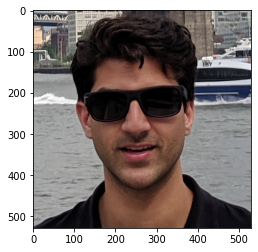

In [0]:
# Male
%cd /content/gdrive/Shared\ drives/CV\ Project\ Datasets/images/male
m_filenames = os.listdir()
m_images = read_images(m_filenames, None)

print(m_filenames)

for image in m_filenames:
  img = plt.imread(image)
  plt.imshow(img)

/content/gdrive/Shared drives/CV Project Datasets/images/female
['0.B.jpg', '1552877239101(2).jpg', '20200423_212929 (3).jpg', 'p1.jpg', 'p2.jpg', 'p3.jpg', 'p4.jpg']


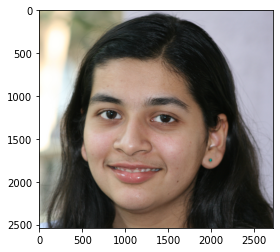

In [0]:
# Female
%cd /content/gdrive/Shared\ drives/CV\ Project\ Datasets/images/female
f_filenames = os.listdir()
f_images = read_images(f_filenames, None)
print(f_filenames)

for image in f_filenames:
  img = plt.imread(image)
  plt.imshow(img)

In [0]:
image_count = np.minimum(len(m_filenames) , len(f_filenames) )
print("Total Image Count: " + str(image_count))
print("Male Image Count: " + str(len(m_filenames)))
print("Female Image Count: " + str(len(f_filenames)))

A = m_images
B = f_images

with torch.no_grad():
  A = Variable( torch.FloatTensor( A )).cuda()
  B = Variable( torch.FloatTensor( B )).cuda()

AB = generator_B(A)
BA = generator_A(B)

ABA = generator_A(AB)
BAB = generator_B(BA)

generator_A.zero_grad()
generator_B.zero_grad()
discriminator_A.zero_grad()
discriminator_B.zero_grad()


for im_idx in range( image_count ):
  A_val = A[im_idx].cpu().data.numpy().transpose(1,2,0) * 255.
  B_val = B[im_idx].cpu().data.numpy().transpose(1,2,0) * 255.
  BA_val = BA[im_idx].cpu().data.numpy().transpose(1,2,0)* 255.
  ABA_val = ABA[im_idx].cpu().data.numpy().transpose(1,2,0)* 255.
  AB_val = AB[im_idx].cpu().data.numpy().transpose(1,2,0)* 255.
  BAB_val = BAB[im_idx].cpu().data.numpy().transpose(1,2,0)* 255.

  filename_prefix = os.path.join ("/content/", str(im_idx))
  imageio.imwrite( filename_prefix + '.A.jpg', A_val.astype(np.uint8)[:,:,::-1])
  imageio.imwrite( filename_prefix + '.B.jpg', B_val.astype(np.uint8)[:,:,::-1])
  imageio.imwrite( filename_prefix + '.BA.jpg', BA_val.astype(np.uint8)[:,:,::-1])
  imageio.imwrite( filename_prefix + '.AB.jpg', AB_val.astype(np.uint8)[:,:,::-1])
  imageio.imwrite( filename_prefix + '.ABA.jpg', ABA_val.astype(np.uint8)[:,:,::-1])
  imageio.imwrite( filename_prefix + '.BAB.jpg', BAB_val.astype(np.uint8)[:,:,::-1])


Total Image Count: 6
Male Image Count: 6
Female Image Count: 7
